# Early-Warning AQI Model (Without Pollutant Indicators)

This notebook builds an AQI prediction model using only meteorological,
temporal, and spatial context variables. Pollutant indicators that directly
contribute to AQI calculation are intentionally excluded to avoid target leakage.

The goal of this model is not maximum accuracy, but to evaluate how well AQI
can be estimated under realistic information constraints.


In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
df = pd.read_csv("/kaggle/input/delhi-aqi-2/delhi_ncr_aqi_dataset.csv")


## Feature Selection (Non-Pollutant)

The following features are used:
- Meteorological variables (temperature, humidity, wind speed, visibility)
- Temporal context (hour, month, year, day of week)
- Spatial context (city)

Although these variables do not directly measure pollution, they may
encode strong historical and seasonal regularities in AQI patterns.


In [16]:
numeric_features = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "hour",
    "month",
    "year",
    "is_weekend"
]

categorical_features = [
    "day_of_week",
    "season",
    "city"
]

X = df[numeric_features + categorical_features]
y = df["aqi"]


In [17]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

encoded = ohe.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(
    encoded,
    columns=ohe.get_feature_names_out(categorical_features),
    index=X.index
)

X = pd.concat(
    [X.drop(columns=categorical_features), encoded_df],
    axis=1
)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [20]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [21]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2


(np.float64(45.19313418817184), 0.9305315911411483)

The relatively high R² does not imply that AQI can be accurately predicted
without pollution data in general. Instead, it reflects strong historical,
seasonal, and spatial regularities specific to the Delhi-NCR region.


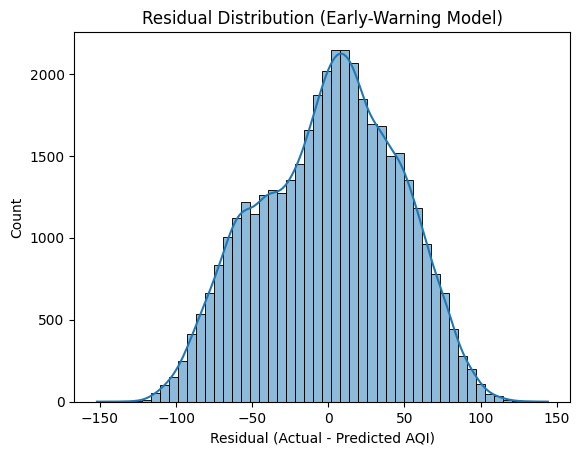

In [23]:
residuals = y_test - y_pred

sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Early-Warning Model)")
plt.xlabel("Residual (Actual - Predicted AQI)")
plt.show()
